# Prediction of User Reactions
We want to predict:
* How to get high score/consensus (upvotes - downvotes)
* How to be controversial (upvotes + downvotes)  
in the comments.

### Import data

In [209]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_09.csv')
df_com = pd.read_csv('comments_2017_09.csv').sample(150000) # crop because battery life
# Make float better readable
pd.options.display.float_format = '{:.3f}'.format

### Prepare features

In [210]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return (get_dt_obj(time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

def get_weekday_hour(time):
    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['time_since_epoch'] = df_com['time'].apply(time_since_epoch)
df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
#df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['con_num_words'] = df_com['con'].apply(lambda x: len(x.split()))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']

df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)
df_art['cat_copy'] = df_art['cat']
df_art = pd.get_dummies(df_art, columns=['cat'])

df_art['header_len'] = df_art['header'].apply(lambda x: len(x))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))
df_art['text_num_words'] = df_art['text'].apply(lambda x: len(str(x).split()))

# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# Remove rows with missing values
# use .count() to check for missing values
df_merge.dropna(axis=0, how='any', inplace=True)

# Get order of comments per article
df_merge = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')

# Get time since the first comment
def get_time_since_first(group):
    first = group.iloc[:1]['time_since_epoch']
    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)
    # Remove those very late comments, after x hours
    #group = group[group['time_since_first'] < 36]
    return group

# Creating "copy" to make next cell independent
df_merge = df_merge.apply(get_time_since_first)
df_merge.head(3)
#df[df.index.duplicated()]

,tId,cId,mob,vup,vdo,tit,aut,time,con,time_since_epoch,...,cat_people,cat_play,cat_playview,cat_schweiz,cat_sport,cat_wissen,header_len,text_len,text_num_words,time_since_first
117896,10003016,1_13,1,190,49,mein erster gedanke,H. M.,am 08.08.2017 07:53,ich denke es auch nicht gerade förderlich wen...,1502178780.000,...,0,0,0,0,0,0,41,3429,509,0.000
117895,10003016,15_15,1,254,15,abgründe,Justitias Hand,am 08.08.2017 07:54,ich war schon beruflich im darknet unterwegs....,1502178840.000,...,0,0,0,0,0,0,41,3429,509,0.017
117893,10003016,43_43,1,248,26,beim ersten bericht mit dem,kein Name,am 08.08.2017 08:17,"entführtem model, war mein erster gedanke; fa...",1502180220.000,...,0,0,0,0,0,0,41,3429,509,0.400


### Trying to remove skew
__Rescaling__: Add or subtract a constant and then multiply or divide by a constant.  
__Normalizing__: Dividing by a norm of the vector, e.g. make Euclidean length equal to one. Sometimes make all elements lie in [0, 1].  
__Standardizing__: Subtracting a measure of location and dividing by a measure of scale. Eg. subtract the mean and divide by the std, thereby obtaining a standard normal distribution.

These terms are sometimes used interchangeably.

It's usually better to have the input values centered around zero, unless the output activation function has a range of [0, 1] (neural networks).

In [211]:

#temp = df[['aut', 'score']].groupby('aut').size().reset_index()
#temp = temp.rename(columns = {0: 'user_n_comments'})
#temp2 = pd.get_dummies(temp[temp['user_n_comments']>60], prefix='user_', columns=['aut'])
#temp = temp.merge(temp2)
#temp.head(2)
#df.head(1)
#user_cols = [col for col in list(df.columns) if col.startswith('user_')]
#print(user_cols)
#df_com[df_com['aut'] == 'Chris'][['aut', 'score']]
#list(df.columns)
#df.groupby('aut')[['aut', 'score']].mean()

In [223]:
import math

# User based information
#temp = df_merge[['aut', 'score']].groupby('aut').mean() # <- this is cheating!
#temp = temp.rename(columns = {'score': 'user_score_mean'}).reset_index()
#df = df_merge.merge(temp, on='aut')
temp = df_merge[['aut']].groupby('aut').size().reset_index()
temp = temp.rename(columns = {0: 'user_n_comments'})
temp2 = pd.get_dummies(temp[temp['user_n_comments']>100], prefix='user', columns=['aut'])
print("users with lots of comments: ", len(temp2))
temp = temp.merge(temp2).reset_index()
df = df_merge.merge(temp, on='aut')

df['con_n_periods'] = df['con'].apply(lambda x: len(x.split('.')))

def sgn(x):
    if x == 0: return 0
    else: return x/abs(x)
# Removes left/right skew 
for col in ['weekday_fl', 'con_len', 'text_len', 'time_since_first', 
            'num_comments', 'user_n_comments', 'con_n_periods',
            'score', 'contr', 'header_len', 'con_num_words', 'text_num_words']:
    df[col + '_trans'] = df[col].apply(lambda x: sgn(x)*math.log(abs(x) + 1))

# Memory optimization
# Technical stuff, contributes nothing to analysis
conv = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[conv.columns] = conv
    
# I removed very weak correlations to "score" and "contr"
cols = ['score', 'score_trans', 'vup', 'vdo', 'weekday', 'hour', 'weekday_fl',
       'con_len_trans', 'text_len_trans', 'con_num_words_trans', 'user_n_comments',
        'text_num_words_trans', 'num_comments', 'num_comments_trans',
       'time_since_first_trans', 'header_len_trans', 'con_n_periods',
        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland',
       'user_Amina123', 'user_Chris', 'user_Dani']
# Get pearson co-efficients
df[cols].corr()

#df.hist('user_score_mean_trans')

#for c in cols:
#    print(c)
#    print(df[np.isnan(df[col])].head(3))

users with lots of comments:  117


,score,score_trans,vup,vdo,weekday,hour,weekday_fl,con_len_trans,text_len_trans,con_num_words_trans,...,header_len_trans,con_n_periods,cat_schweiz,cat_finance,cat_sport,cat_wissen,cat_ausland,user_Amina123,user_Chris,user_Dani
score,1.000,0.481,0.964,0.114,0.003,-0.004,0.002,0.026,0.012,0.024,...,0.019,0.025,0.027,-0.037,-0.006,-0.013,0.012,0.020,-0.004,-0.012
score_trans,0.481,1.000,0.372,-0.285,-0.002,-0.003,-0.002,0.058,-0.001,0.054,...,0.007,0.024,0.011,-0.038,-0.001,0.000,0.011,0.029,-0.008,-0.010
vup,0.964,0.372,1.000,0.376,0.005,-0.002,0.005,0.033,0.016,0.031,...,0.020,0.029,0.033,-0.047,-0.004,-0.018,0.026,0.017,-0.002,-0.009
vdo,0.114,-0.285,0.376,1.000,0.008,0.008,0.009,0.032,0.018,0.032,...,0.008,0.022,0.031,-0.048,0.005,-0.024,0.054,-0.007,0.007,0.007
weekday,0.003,-0.002,0.005,0.008,1.000,0.027,0.993,-0.006,-0.031,-0.008,...,-0.038,-0.006,-0.029,-0.018,0.022,0.022,-0.019,-0.019,-0.022,0.002
hour,-0.004,-0.003,-0.002,0.008,0.027,1.000,0.145,-0.053,-0.030,-0.051,...,0.015,-0.013,-0.031,-0.013,0.012,0.039,-0.003,0.013,-0.015,-0.012
weekday_fl,0.002,-0.002,0.005,0.009,0.993,0.145,1.000,-0.012,-0.034,-0.014,...,-0.036,-0.008,-0.033,-0.020,0.023,0.026,-0.019,-0.017,-0.024,0.000
con_len_trans,0.026,0.058,0.033,0.032,-0.006,-0.053,-0.012,1.000,0.066,0.989,...,0.017,0.562,0.026,0.044,-0.047,-0.002,0.063,-0.026,0.019,0.013
text_len_trans,0.012,-0.001,0.016,0.018,-0.031,-0.030,-0.034,0.066,1.000,0.065,...,0.066,0.025,0.173,0.054,-0.015,-0.022,0.087,-0.023,0.002,0.006
con_num_words_trans,0.024,0.054,0.031,0.032,-0.008,-0.051,-0.014,0.989,0.065,1.000,...,0.013,0.558,0.025,0.043,-0.039,-0.004,0.057,-0.039,0.019,0.014


### Prepare and split for model

In [226]:
# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für"
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns"
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier"
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

X = df.drop(['score', 'contr', 'vup', 'vdo'], axis=1)
y = df['score']

from sklearn.model_selection import train_test_split, learning_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("total data: ", len(X))

def plot_learning_curve(estimator, X, y, ylim=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title('Learning curve')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples'); plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

total data:  32562


### Model 

PicklingError: Can't pickle <function <lambda> at 0x156e932f0>: attribute lookup <lambda> on __main__ failed

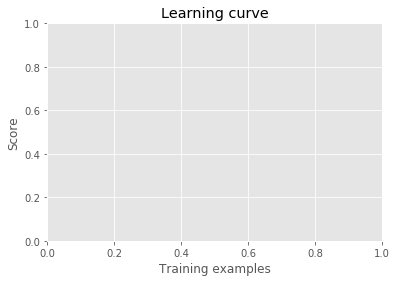

In [225]:
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    '''
    Select a subset of data at a provided key.
    key: hashable, required
        The key corresponding to the desired value in a mappable.
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]
    
ngram_range = (1, 1)
user_cols = [col for col in list(df.columns) if col.startswith('user_')]
no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
model = Pipeline([
    ('union', FeatureUnion(
        [
            # comment + user information
            ('statistics', Pipeline([
                ('selector', ItemSelector(
                    key=['weekday', 'hour', 'con_len_trans', 'num_comments', 
                         'time_since_first_trans',# 'con_num_words',
                          #'user_n_comments_trans', #'con_n_periods_trans',
                        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland',
                         'cat_panorama', 'cat_community', 'cat_people', 'cat_digital'
                        ])), #+ user_cols)),
                # Polynomialfeatures can help a little bit...
#                ('polynomialfeatures', PolynomialFeatures(degree=2)),
            ])),

            ('words_content', Pipeline([
                ('selector', ItemSelector(key='con')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range)),
                ('best', TruncatedSVD(n_components=30)),
            ])),
            
            # article information
            ('words_title', Pipeline([
                ('selector', ItemSelector(key='tit')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range)),
                ('best', TruncatedSVD(n_components=30)),
            ])),
            
            ('words_subtitle', Pipeline([
                ('selector', ItemSelector(key='sub')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range)),
                ('best', TruncatedSVD(n_components=30)),
            ])),
            
            ('words_text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('tfidf', TfidfVectorizer(min_df=0.2, max_df=0.7, preprocessor=no_numbers, ngram_range=(1, 2))),
                ('best', TruncatedSVD(n_components=30)),
            ])),

        ]
    )),    
    #('model', MLPRegressor(max_iter=50, hidden_layer_sizes=(100,)))
    ('model', GradientBoostingRegressor(n_estimators=10, max_depth=2))
])

if True:
    plot_learning_curve(model, X, y)
    plt.show()
else:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R^2: %1.3f" % r2_score(y_test, y_pred))
    print("Explained var: {:3f}".format(explained_variance_score(y_test, y_pred)))

    # Residual plot
    # time_since_first because it seems to have some influence (see feature importance below)
    X_res = X_test['time_since_first_trans']
    plt.scatter(X_res, y_test, color='black', label='test data')
    plt.scatter(X_res, y_pred, color='red', label='predicted')
    plt.xlabel('time_since_first_trans')
    plt.legend(); plt.show()

    if False:
        from sklearn.model_selection import GridSearchCV
        param_grid = {
            'model__hidden_layer_sizes':[(50,), (100,), (200,), (100, 50)]
    #        'motdel__alpha': np.logspace(-1, 4, 6),
                     }
        grid = GridSearchCV(model, param_grid, cv=3)
        grid.fit(X_train, y_train)

        print(grid.best_params_)

### Summary so far
The decision tree regressor depends a lot on max_depth parameter: Depending on it, the model over- or underfits. I reached the best R^2 score with max_depth=3, but model underfits.

Neural networks work a bit better: R^2 = 0.39 (old try)  
GBRF same: R^2 = 0.45  
ngram range (1, 2): 0.37  ngram range (1, 1): 0.366   
adding more stop words: gives a very small increase

The models improve slightly with more data, will try bigger runs.

How to extract more information? How to use user behaviour?

TODO: better text feature extration. Save trained model, make a prediction function where it's easy to input data to try around with score prediction.

In [215]:
# Try to find out which features are not important
# It seems that the text features are rather important

fi = model.named_steps['model'].feature_importances_
print(len(['weekday', 'hour', 'con_len_trans', 'num_comments', 
                         'time_since_first_trans',# 'con_num_words',
                          'user_n_comments_trans', #'con_n_periods_trans',
                        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland',
                         'cat_panorama', 'cat_community', 'cat_people', 'cat_digital'
                       ] + user_cols))
print(len(fi[:-130]))
print('content')
print(fi[-130:-90])
print('tit')
print(fi[-90:-60])
print('sub')
print(fi[-60:-30])
print('text')
print(fi[-30:])

325
325
content
[  3.36235444e-02   0.00000000e+00   0.00000000e+00   1.46943118e-02
   5.39431393e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   3.52756075e-02   1.00141627e-02   0.00000000e+00
   0.00000000e+00   6.19984651e-05   0.00000000e+00   2.21207406e-03
   9.16771433e-03   0.00000000e+00   1.50467028e-03   0.00000000e+00
   6.84321173e-03   3.16848264e-04   4.26150697e-03   0.00000000e+00
   0.00000000e+00   1.18311252e-02   4.28463174e-03   2.89814845e-04
   0.00000000e+00   4.17726172e-03   5.19424009e-03   2.56189331e-02
   1.22325594e-02   7.79614393e-02   5.11375025e-03   3.02468885e-03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
tit
[ 0.02023909  0.          0.00290409  0.          0.          0.03166067
  0.          0.0021474   0.          0.0025421   0.          0.
  0.02493418  0.          0.          0.00115153  0.00811151  0.
  0.00852716  0.          0.00181089  0.          0.          0.          0.
  0.     